This code will have the main plotting functions, so it is easier to follow, step by step, in the mortality analysis plot. 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colormaps
import geopandas as gpd
from scipy.stats import linregress
from scipy.stats import norm
import seaborn as sns
import colorcet as cc

In [77]:
"""
we load the cleaned data.
"""
df_comarques_total = gpd.read_file("./Data/df_comarques_total.gpkg")
df_comarques_men   = gpd.read_file("./Data/df_comarques_men.gpkg")
df_comarques_women = gpd.read_file("./Data/df_comarques_women.gpkg")

In [78]:

cause = "cardiac rel_norm"
ohca = "ohca rel_norm"
cov_desfi = "coverage_desfi_norm"
cov_hospi = "coverage_hospi_norm"
pob_norm = "pob_norm"
df_plot = df_comarques_total.copy()

def plot_simple(df_plot, variable = "cardiac rel_norm", title = "Cardiac arrests", save = "cardio"):
    vals = df_plot[f'{variable}']
    
    cmap = plt.cm.viridis
    
    # Create a TwoSlopeNorm centered at 0
    vmin = vals.min()
    vmax = vals.max()
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot non-zero municipalities
    df_plot.plot(
        column=f'{variable}',
        cmap=cmap,
        norm = norm,# color map for positive values (cc.cm["dimgray_r"])
        legend=False,
        legend_kwds={'shrink': 0.5},
        ax=ax,
        edgecolor='black',
        linewidth=0.5
    )
    """
    if variable == "pob_norm":
        ax.set_title(f'{title}', fontsize=16)
    else:
        ax.set_title(f'{title} per 100k inhabitants', fontsize=16)
    """
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f'./plots/{save}.png')
    plt.close()
    plt.show()

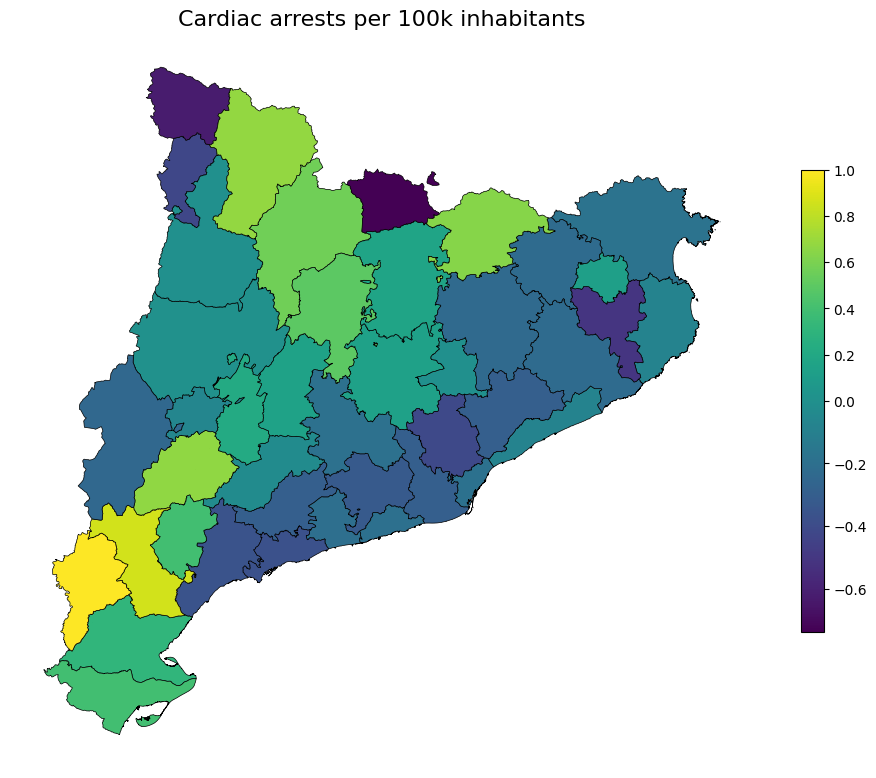

In [32]:
plot_simple(df_plot, variable = "cardiac rel_norm", title = "Cardiac arrests")

In [79]:
"""
We compute a relationship between cardiac arrests and AED quantities
We also compute the regression coefficients for points that we don't consider as outliers, so their
coverage enters a 95 interval of confidence. We can add or retract those values.

# Confidence level
conf = 0.95
z = norm.ppf((1 + conf) / 2)
mean_cov = df_plot[f'{cov}'].mean()
std_cov  = df_plot[f'{cov}'].std()
lower = mean_cov - z * std_cov
upper = mean_cov + z * std_cov

# Filter values within CI
df_plot = df_plot[(df_plot[f'{cov}'] >= lower) & (df_plot[f'{cov}'] <= upper)]
"""

def scatter_plot(df_plot, x_val = "cardiac rel_norm", y_val = "coverage_desfi_norm",
                 x_axis = "cardiac arrests", y_axis = "AED locations", save = "cardio"):
    sns.scatterplot(
        data=df_plot,
        y=f'{cov_desfi}',
        x=f'{cause}',
        alpha=0.6,
        color='blue'
    )
    
    
    # Regression ONLY on filtered data
    sns.regplot(
        data=df_plot,
        y=f'{cov_desfi}',
        x=f'{cause}',
        scatter=False,      # do NOT plot points again
        ci=95,
        color='red',
        line_kws={'linewidth':2}
    )
    plt.ylabel(f'{y_axis}')
    plt.xlabel(f'{x_axis}')
    #plt.title('Coverage vs Cardiovascular Deaths per Comarca with Trend and CI')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"./plots/{save}.png")
    plt.close()


scatter_plot(df_plot, x_val = ohca, y_val = cov_desfi,
                 x_axis = "OHCA incidence", y_axis = "AED locations", save = "cardiac_AED")


res = linregress(
    y = df_plot[f'{cov}'],
    x = df_plot[f'{cause}']
)

print("Slope:", res.slope)
print("Intercept:", res.intercept)
print("R²:", res.rvalue**2)
print("p-value:", res.pvalue)
print("Std err:", res.stderr)




Slope: 0.34547742650181257
Intercept: 0.07142857142857147
R²: 0.09283291679968535
p-value: 0.04977166997134706
Std err: 0.1707584970920311


In [80]:
"""
We create the bipartite map, and highlight points above the diagonal in the 2 dimensional map. This should 
be the main result in our plotting algorithms.
"""

def adjust_color_for_diagonal(color, x_center, y_center):
    """
    Brighten color if y > x, darken if y < x.
    x_center, y_center = bin center values.
    """
    r, g, b, a = color

    # Compare diagonal
    if y_center > x_center:      # above diagonal → brighten
        factor = 1.25
    elif y_center < x_center:    # below diagonal → darken
        factor = 0.75
    else:
        factor = 1.0

    r = min(1, r * factor)
    g = min(1, g * factor)
    b = min(1, b * factor)

    return (r, g, b, a)


def bivariate_choropleth(
    df,
    cause,
    cov,
    num_bins=6,
    cmap_name='cividis',
    figsize=(12, 12),
    inset_size=("30%", "30%"),
    inset_loc='lower right',
    highlight_quadrant=True,     
    edgewidth_highlight=2.0,
    x_axis = "cardiac",
    y_axis = "coverage",
    title = "Cardiac arrests per 100,000 inhabitants",
    save = "cardiac",
):
    """
    Draws a 6×6 bivariate choropleth with an inset scatter plot.

    Adds two columns to df:
        - 'bin_idx'
        - 'plot_color'
    """

    df_plot = df.copy()

    x = df_plot[cause].values
    y = df_plot[cov].values

    # Bin ranges
    x_min, x_max = np.floor(x.min()), np.ceil(x.max())
    y_min, y_max = np.floor(y.min()), np.ceil(y.max())

    x_bins = np.linspace(x_min, x_max, num_bins + 1)
    y_bins = np.linspace(y_min, y_max, num_bins + 1)

    # Digitize non-zero values
    x_idx = np.digitize(x, x_bins, right=True) - 1
    y_idx = np.digitize(y, y_bins, right=True) - 1

    x_idx = np.clip(x_idx, 0, num_bins - 1)
    y_idx = np.clip(y_idx, 0, num_bins - 1)

    bin_idx = y_idx * num_bins + x_idx
    
    # Create discrete color palette
    cmap_cont = colormaps.get_cmap(cmap_name)
    colors = []
    for j in range(num_bins):
        for i in range(num_bins):
            base_color = cmap_cont((j*num_bins + i) / (num_bins**2 - 1))
            
            # bin center coordinates
            x_center = (x_bins[i] + x_bins[i+1]) / 2
            y_center = (y_bins[j] + y_bins[j+1]) / 2
    
            adj_color = adjust_color_for_diagonal(base_color, x_center, y_center)
            colors.append(adj_color)
    
    # Assign colors to all comarcas
    plot_colors = []
    plot_colors = [colors[bin_idx[i]] for i in range(len(df_plot))]

    # Add to dataframe
    full_bin_idx = np.zeros(len(df_plot), dtype=int)
    full_bin_idx = bin_idx
    df_plot['bin_idx'] = full_bin_idx
    df_plot['plot_color'] = plot_colors

    if highlight_quadrant:
        df_plot['highlight'] = (
            (df_plot[cause] >= 0) &
            (df_plot[cov] <= 0)
        )
    else:
        df_plot['highlight'] = False
    
    # --- PLOT ---
    fig, ax_map = plt.subplots(figsize=figsize)

    df_plot[~df_plot['highlight']].plot(
        color=df_plot.loc[~df_plot['highlight'], 'plot_color'],
        ax=ax_map,
        edgecolor='black',
        linewidth=0.5
    )

    if highlight_quadrant:
        df_plot[df_plot['highlight']].plot(
            color=df_plot.loc[df_plot['highlight'], 'plot_color'],
            ax=ax_map,
            edgecolor='red',
            linewidth=edgewidth_highlight,
            zorder=5
        )
    
    ax_map.axis('off')
    #ax_map.set_title(f"{title}", fontsize=16)

    # --- Inset scatter ---
    ax_inset = inset_axes(
        ax_map,
        width=inset_size[0],
        height=inset_size[1],
        loc=inset_loc,
        borderpad=1
    )

    # Background grid
    for i in range(num_bins):
        for j in range(num_bins):
            rect_color = colors[j*num_bins + i]
            ax_inset.add_patch(
                plt.Rectangle(
                    (x_bins[i], y_bins[j]),
                    x_bins[i+1] - x_bins[i],
                    y_bins[j+1] - y_bins[j],
                    facecolor=rect_color,
                    edgecolor='white',
                    alpha=0.7
                )
            )

    # Red x = y diagonal
    ax_inset.plot(
        [x_min, x_max],
        [y_min, y_max],
        color='black',
        linestyle='--',
        linewidth=1
    )

    # Scatter points
    ax_inset.scatter(
        x,
        y,
        c=[colors[i] for i in bin_idx],
        edgecolor='k',
        alpha=0.8
    )

    # Axes settings
    ax_inset.set_xticks(x_bins)
    ax_inset.set_yticks(y_bins)
    ax_inset.set_xlim(x_min, x_max)
    ax_inset.set_ylim(y_min, y_max)

    for spine in ax_inset.spines.values():
        spine.set_visible(False)

    ax_inset.set_xlabel(x_axis, fontsize=8)
    ax_inset.set_ylabel(y_axis, fontsize=8)
    ax_inset.tick_params(axis='both', labelsize=8)

    #plt.tight_layout()
    plt.savefig(f'./plots/{save}.png')
    plt.close()

In [83]:
bivariate_choropleth(
    df_comarques_total,
    cause=ohca,
    cov=cov_desfi,
    num_bins=6,
    x_axis = "OHCA incidence",
    y_axis = "AED coverage",
    title = "Spatial distribution between OHCA and AED coverage",
    save = "cardia_arrest_AED",
)

bivariate_choropleth(
    df_comarques_total,
    cause=ohca,
    cov=cov_hospi,
    num_bins=6,
    x_axis = "OHCA incidence",
    y_axis = "Medical units coverage",
    title = "Spatial distribution between OHCA and medical unit coverage",
    save = "cardiac_arrest_HOSP",
)

bivariate_choropleth(
    df_comarques_total,
    cause=ohca,
    cov=pob_norm,
    num_bins=6,
    x_axis = "OHCA incidence",
    y_axis = "Population density",
    title = "Spatial distribution between OHCA incidence and population density",
    save = "cardiac_arrest_pop",
)

We see in the above plot that there are many points below the cardiac arrests with AED coverage. This essentially means that all thos points have more cardiac arrests than the expected AED coverage accounts for. More over, we can also compare this with a population vs cardiac arrest plot:

In [82]:
plot_simple(df_plot, variable = cov_hospi, title = "Medical centers coverage", save = "med_units_simple")
plot_simple(df_plot, variable = pob_norm, title = "Normalised population", save = "pob_simple")
plot_simple(df_plot, variable = cov_desfi, title = "AED coverage", save = "aed_units_simple")
plot_simple(df_plot, variable = ohca, title = "OHCA coverage", save = "ohca_units_simple")